# Demonstrating `mobile-env` (Steps 1&2 of 4)

`mobile-env` is a simple and open environment for training, testing, and evaluating autonomous coordination
approaches for wireless mobile networks.

* `mobile-env` is written in pure Python and can be installed easily via [PyPI](https://pypi.org/project/mobile-env/)
* It allows simulating various scenarios with moving users in a cellular network with multiple base stations
* `mobile-env` implements the standard [Gymnasium](https://gymnasium.farama.org/) (previously [OpenAI Gym](https://gym.openai.com/)) interface such that it can be used with all common frameworks for reinforcement learning
* `mobile-env` is not restricted to reinforcement learning approaches but can also be used with conventional control approaches or dummy benchmark algorithms
* It supports both centralized, single-agent control and distributed, multi-agent control
* It can be configured easily (e.g., adjusting number and movement of users, properties of cells, etc.)
* It is also easy to extend `mobile-env`, e.g., implementing different observations, actions, or reward

As such `mobile-env` is a simple platform to evaluate and compare different coordination approaches in a meaningful way.



**Demonstration Steps:**

This demonstration consists of the following steps (split accross separate notebooks):

1. **This notebook**: Installation and usage of `mobile-env` with dummy actions
2. **This notebook**: Configuration of `mobile-env` and adjustment of the observation space (optional)
3. [SB3 notebook](examples\sb3.ipynb): Training a single-agent reinforcement learning approach with [`stable-baselines3`](https://github.com/DLR-RM/stable-baselines3)
4. [RLlib notebook](examples\rllib.ipynb): Training a multi-agent reinforcement learning approach with [Ray RLlib](https://docs.ray.io/en/latest/rllib.html)


## Step 1: Install and Test `mobile-env` With Dummy Actions

Installing `mobile_env` via PyPI is very simple:

In [2]:
# installation via PyPI
!pip install -U mobile-env

`mobile_env` comes with a set of predefined scenarios, registered as Gymnasium environments, that can be used out of the box for quick experimentation.

In [3]:
import gymnasium
import matplotlib.pyplot as plt
# importing mobile_env automatically registers the predefined scenarios in Gym
import mobile_env

# create a small mobile environment for a single, centralized control agent
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make("mobile-small-central-v0", render_mode="rgb_array")

print(f"\nSmall environment with {env.NUM_USERS} users and {env.NUM_STATIONS} cells.")


Small environment with 5 users and 3 cells.


Here, we consider a small scenario (called `"mobile-small-central-v0"`) with 5 users and 3 cells.
As the users move around, the goal is to connect the users to suitable cells, ensuring that all users have a good Quality of Experience (QoE).

Using coordinated multipoint (CoMP), users can connect to multiple cells simultaneously.
Connecting to more cells increases the user's data rate but also increases competition for resources and may decrease data rates of other users.
Therefore, a good coordination policy needs to balance this trade-off, depending on available resources and users' positions (affecting their path loss).

To measure QoE, `mobile-env` defaults to a logarithmic utility function of the users' data rate, where -20 indicates bad QoE and +20 indicates good QoE. This can be easily configured and changed.

![Utility plot](https://raw.githubusercontent.com/stefanbschneider/mobile-env/main/docs/images/utility.png)

To get started, we will use random dummy actions.

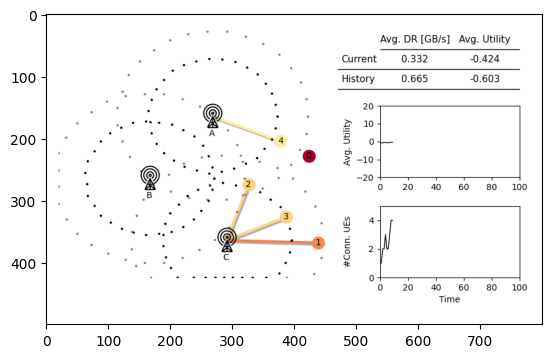

In [4]:
from IPython import display

# run the simulation for 10 time steps
done = False
obs, info = env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

The rendered environment shows the three cells as cell towers with circles indicating their range.
The five moving users are shown as small circles, where the number indicates the user ID and
the color represents the user's current QoE (red = bad, yellow = ok, green = good).

A line between a user and a cell indicates that the user is connected to the cell.
Again, the line color indicates the QoE that's achieved via the connection.
Note that users can connect to multiple cells simultaneously using coordinated multipoint (CoMP).

Here, with random action, users sometimes connect to cells but are oftentimes also completely disconnected from any cells, leading to bad QoE (red circles).

Before training a reinforcement learning agent to properly control cell selection, we will look at some configuration options of `mobile-env` next. If you are in a hurry, feel free to skip this step.



## Step 2: Configure `mobile-env` (Optional)

### Predefined Scenarios

Configuration is optional.
We can also choose between one of the [three predefined scenarios](https://mobile-env.readthedocs.io/en/latest/components.html#scenarios) (small, medium, and large) without having to configure anything.

By default, these are available for either a single, centralized agent (e.g., `"mobile-small-central-v0"`)
or multiple agents (e.g., `"mobile-small-ma-v0"`), which affects the observations, actions, and reward.

In [5]:
# predefined small scenarios
from mobile_env.scenarios.small import MComSmall

# easy access to the default configuration
MComSmall.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 0,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.ResourceFair,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.central.MComCentralHandler,
 'bs': {'bw': 9000000.0, 'freq': 2500, 'tx': 30, 'height': 50},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'arrival_params': {'ep_time': 100, 'reset_rng_episode': False},
 'channel_params': {},
 'scheduler_params': {},
 'movement_params': {'width': 200, 'height': 200, 'reset_rng_episode': False},
 'utility_params': {'lower': -20, 'upper': 20, 'coeffs': (10, 0, 10)},
 'metrics': {'scalar_metrics': {}, 'ue_metrics': {}, 'bs_metrics': {}}}

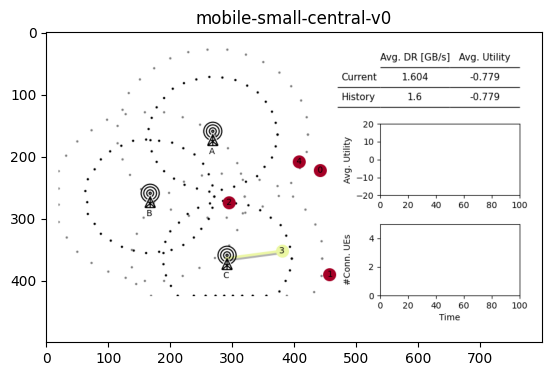

In [6]:
def plot_env(env_name):
    """Create env, take a random step, and then render the environment."""
    env = gymnasium.make(env_name, render_mode="rgb_array")
    env.reset()
    env.step(env.action_space.sample())
    plt.imshow(env.render())
    plt.title(env_name)

# plot small env from earlier
plot_env("mobile-small-central-v0")

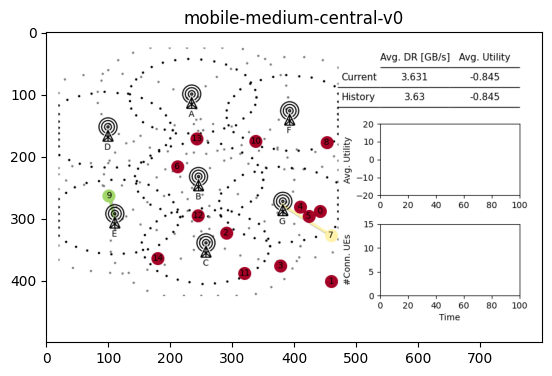

In [7]:
plot_env("mobile-medium-central-v0")

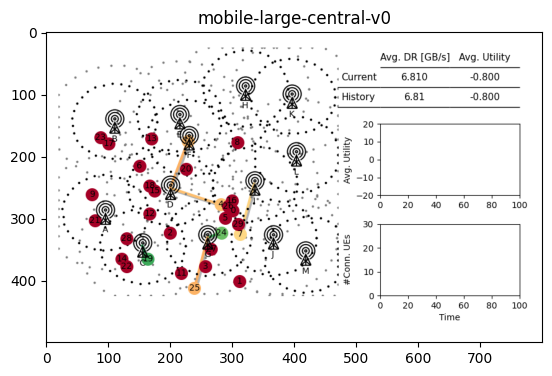

In [8]:
plot_env("mobile-large-central-v0")

### Custom Scenario

It is also easy to define a custom scenario by subclassing `mobile-env`'s `MComCore` base class.

Here, we create a custom scenario with two cells and three users, where one user is stationary and the other two users move quickly with 10 m/s.

We also configure the environment to simulate each episode with identical user positions and movement. By default, users appear and move randomly in each episode.
We also set the episode length to 10 (instead of default 100 steps).

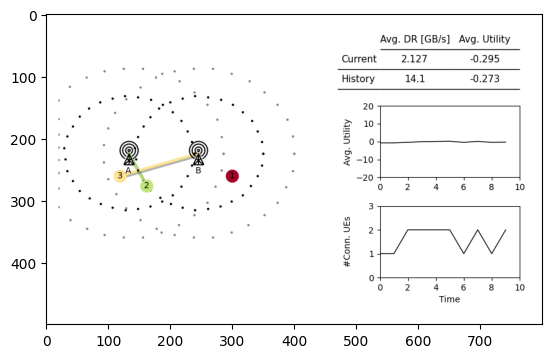

In [9]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment


class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # 10 steps per episode
            "EP_MAX_TIME": 10,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(50, 100), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
            # stationary user --> set velocity to 0
            UserEquipment(ue_id=3, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
        ]

        super().__init__(stations, users, config, render_mode)


# init and render the custom scenario
env = CustomEnv(render_mode="rgb_array")
env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Extending `mobile-env`: Tracking custom metrics

`mobile-env` allows to define and track custom metrics during the training and testing phases. It defines an interface for metrics that record values per user equipment (e.g. utility per user), basestation (e.g. number of connections per station) or time step (e.g. average utility of users).

Here, we show as an example how the number of overall connections, connections per station and utility per user can be monitored. Also, we track each user's distance to their closest station. Later, we load the monitored metrics as `pandas` data frames.

In [10]:
import numpy as np

# overall number of active connections
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}


# monitors each user equipments' distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestations
    bpos = np.array([[bs.x, bs.y] for bs in sim.stations.values()])

    distances = {}    
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2, axis=1)).min()
        
        distances[ue_id] = dist
    
    return distances


# number of connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}



# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall connections": overall_connections},
            "ue_metrics": {"user utility": user_utility, 'distance station': user_closest_distance},
            "bs_metrics": {"station connections": station_connections}
            }
         }
    
# pass the configuration to the environment
env = gymnasium.make("mobile-small-central-v0", config=config, render_mode="rgb_array")
env.reset()

for _ in range(40):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
plt.close()
          
        
# load all tracked results as pandas data frames
scalar_results, ue_results, bs_results = env.monitor.load_results()

# show general specific results
scalar_results.head()

,overall connections,number connections,number connected,mean utility,mean datarate
Time Step,,,,,
0,1,1,1,-0.779477,1.604097
1,1,1,1,-0.828865,0.514459
2,0,0,0,-1.000000,0.000000
3,1,1,1,-0.838724,0.409979
4,0,0,0,-1.000000,0.000000


Using the monitored metrics per user equipment, we analyse the average, maximum and minimum distance and utility per user.

In [11]:
data = ue_results.reset_index()
data = data.groupby('UE ID').agg(['mean', 'min', 'max'])
data = data.drop('Time Step', axis='columns')
data.head()

Metric distance station                       user utility               
                   mean        min        max         mean  min       max
UE ID                                                                    
0             67.215703  52.943728  83.360218    -0.965909 -1.0 -0.266338
1             60.145925  51.157285  76.509602    -0.616329 -1.0 -0.063919
2             56.253197  45.321201  74.520349    -0.610777 -1.0 -0.056056
3             58.155210  40.677124  75.709291    -0.705642 -1.0  0.102615
4             40.510698  16.895876  67.734091    -0.293349 -1.0  0.729975

### Extending `mobile-env`: Adding a Handler for a Custom Observation Space

Handlers define the observation and action spaces as well as the reward for an environment.
Hence, when designing a new Markov Decision Process for a reinforcement learning approach, you can quickly validate it by implementing a new handler in `mobile-env`.

Let's first look at the default handler (for single-agent RL) and then add a new handler with a custom observation space.

In [12]:
env.handler.features

['connections', 'snrs', 'utility']

By default, observed features are:
* The current connections between users and cells (binary)
* The signal-to-noise-ratio (SNR) between all users and cells (normalized to [0,1])
* The current utility (i.e., QoE) of each user (normalized to [-1,1])

In [13]:
env = CustomEnv(config={"seed": 42})
obs, info = env.reset(seed=42)
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("Raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 1
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS:offset+2*env.NUM_STATIONS]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS]}")


Raw observations:  [ 0.          0.          0.3470676   1.         -1.          0.
  0.          1.          0.2665389  -1.          0.          0.
  0.38201445  1.         -1.        ]

Observations for user 1:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [0.3470676 1.       ]
Current utility: -1.0

Observations for user 2:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [1.        0.2665389]
Current utility: -1.0

Observations for user 3:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [0.38201445 1.        ]
Current utility: -1.0


Now, let's extend the observation space by adding an observation that indicates whether a user is connected to any cell at all, i.e., a single binary entry per user.

For that, we create a new handler that inherits from the existing central handler and simply overwrite the relevant parts: The available features and the observations.

In [14]:
from mobile_env.handlers.central import MComCentralHandler
import numpy as np


class CustomHandler(MComCentralHandler):
    # let's call the new observation "any_connection"
    features = MComCentralHandler.features + ["any_connection"]

    # overwrite the observation size per user
    @classmethod
    def ue_obs_size(cls, env) -> int:
        """Increase observations by 1 for each user for the new obs"""
        # previously: connections for all cells, SNR for all cells, utility
        prev_size = env.NUM_STATIONS + env.NUM_STATIONS + 1
        return prev_size + 1

    # add the new observation
    @classmethod
    def observation(cls, env) -> np.ndarray:
        """Concatenated observations for all users"""
        # get all available obs from the env
        obs_dict = env.features()

        # add the new observation for each user (ue)
        for ue_id in obs_dict.keys():
            any_connection = np.any(obs_dict[ue_id]["connections"])
            obs_dict[ue_id]["any_connection"] = int(any_connection)

        # select the relevant obs and flatten into single vector
        flattened_obs = []
        for ue_id, ue_obs in obs_dict.items():
            flattened_obs.extend(ue_obs["connections"])
            flattened_obs.append(ue_obs["any_connection"])
            flattened_obs.extend(ue_obs["snrs"])
            flattened_obs.extend(ue_obs["utility"])

        return flattened_obs

In [15]:
# create the env with the new handler and check the obs
env = CustomEnv(config={"handler": CustomHandler})
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("New, raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 2
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"NEW: Any connection?: {obs[offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS+1]}")

New, raw observations:  [0.0, 0.0, 0, 0.39157578, 1.0, -1.0, 0.0, 1.0, 1, 0.08438771, 1.0, -0.29772076, 0.0, 1.0, 1, 1.0, 0.021902867, -0.32705253]

Observations for user 1:
Current connections to the 2 cells: [0.0, 0.0]
NEW: Any connection?: 0
SNR to the 2 cells: [0.39157578, 1.0]
Current utility: -1.0

Observations for user 2:
Current connections to the 2 cells: [0.0, 1.0]
NEW: Any connection?: 1
SNR to the 2 cells: [0.08438771, 1.0]
Current utility: -0.2977207601070404

Observations for user 3:
Current connections to the 2 cells: [0.0, 1.0]
NEW: Any connection?: 1
SNR to the 2 cells: [1.0, 0.021902867]
Current utility: -0.3270525336265564
